# Score vs Pathwise Gradient

In [1]:
from birds.models.sir import SIR
from birds.calibrator import Calibrator

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx
import pygtc
import normflows as nf

In [2]:
n_agents = 1000
graph = networkx.watts_strogatz_graph(n_agents, 10, 0.1)
sir = SIR(graph, n_timesteps=100)

In [3]:
true_parameters = torch.tensor([0.05, 0.05, 0.05]).log10()
true_data = sir(true_parameters) 


In [4]:
prior = torch.distributions.MultivariateNormal(-2.0 * torch.ones(3), torch.eye(3))

In [5]:
def setup_flow():
    K = 4
    torch.manual_seed(0)
    
    latent_size = 3
    hidden_units = 64
    hidden_layers = 2
    
    flows = []
    for i in range(K):
        flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
        flows += [nf.flows.LULinearPermute(latent_size)]
    
    # Set prior and q0
    q0 = nf.distributions.DiagGaussian(3, trainable=False)
        
    # Construct flow model
    flow = nf.NormalizingFlow(q0=q0, flows=flows)
    return flow

In [7]:
def train_estimator(gradient_estimation_mode):
    posterior_estimator = setup_flow() 
    optimizer = torch.optim.Adam(posterior_estimator.parameters(), 1e-3)
    calibrator = Calibrator(model = sir, 
                            posterior_estimator=posterior_estimator, 
                            prior=prior, 
                            data=true_data, 
                            optimizer=optimizer,
                            w = 0.0, 
                            gradient_estimation_method=gradient_estimation_mode,
                   )
    calibrator.run(250, max_epochs_without_improvement=np.inf)
    return calibrator

In [8]:
%%time
calibrator_pathwise = train_estimator("pathwise")

100%|███████████████████████████████████████████████████████████████████| 250/250 [04:59<00:00,  1.20s/it, Forecast=1.64e+4, Reg.=0, total=1.64e+4, best loss=565, epochs since improv.=85]

CPU times: user 4min 50s, sys: 2min 9s, total: 6min 59s
Wall time: 4min 59s


In [9]:
%%time
calibrator_score = train_estimator("score")

100%|███████████████████████████████████████████████████████████████| 250/250 [02:33<00:00,  1.63it/s, Forecast=1.98e+5, Reg.=0, total=1.98e+5, best loss=3.52e+4, epochs since improv.=23]

CPU times: user 2min 38s, sys: 1min 50s, total: 4min 28s
Wall time: 2min 33s


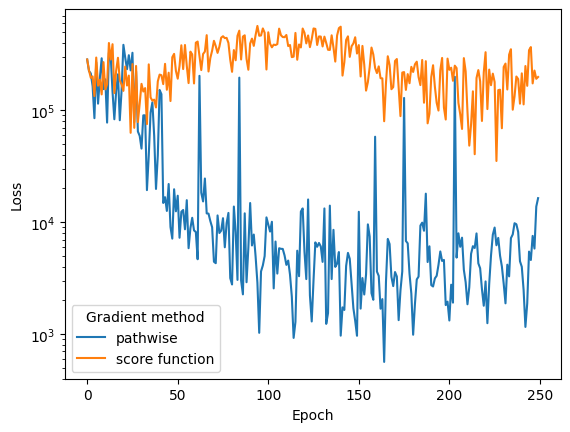

In [12]:
f, ax = plt.subplots()
ax.plot(calibrator_pathwise.losses_hist["total"], label = "pathwise")
ax.plot(calibrator_score.losses_hist["total"], label = "score function")
ax.set_yscale("log")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend(title="Gradient method")

In [164]:
calibrator_pathwise.posterior_estimator.load_state_dict(calibrator_pathwise.best_model_state_dict)
calibrator_score.posterior_estimator.load_state_dict(calibrator_score.best_model_state_dict)

<All keys matched successfully>

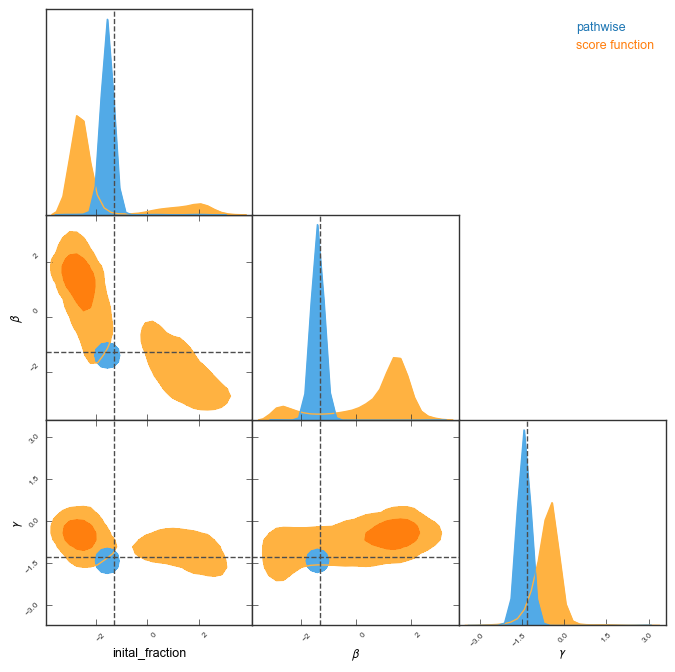

In [15]:
samples_pw = calibrator_pathwise.posterior_estimator.sample(10000)[0].detach().numpy()
samples_score = calibrator_score.posterior_estimator.sample(10000)[0].detach().numpy()

pygtc.plotGTC(chains=[samples_pw, samples_score], figureSize=8, truths = true_parameters.numpy(), chainLabels=["pathwise", "score function"], paramNames=["inital_fraction", r"$\beta$", r"$\gamma$"]);

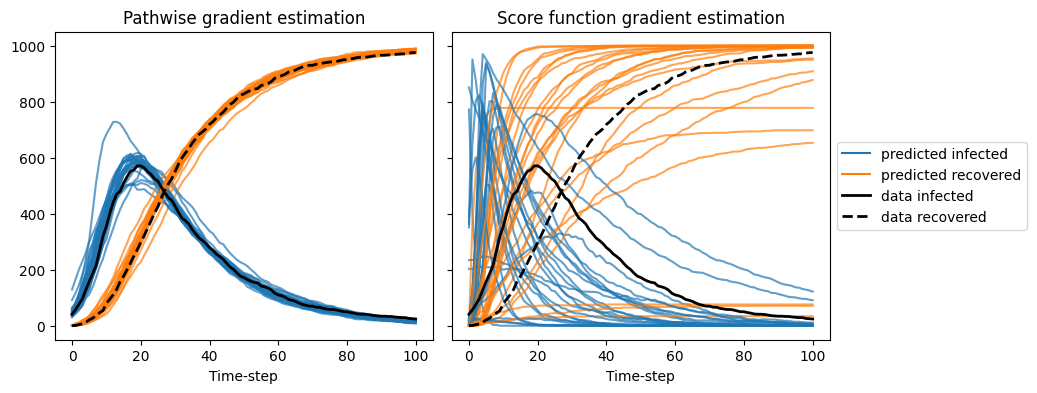

In [184]:
# compare the predictions to the synthetic data:

f, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
alpha=0.7

for i in range(25):
    with torch.no_grad():
        sim_sir_pw = sir(calibrator_pathwise.posterior_estimator.sample(1)[0][0])
        ax[0].plot(sim_sir_pw[0].numpy(), color = "C0", alpha=alpha)
        ax[0].plot(sim_sir_pw[1].numpy(), color = "C1", alpha=alpha)
        sim_sir_score = sir(calibrator_score.posterior_estimator.sample(1)[0][0])
        ax[1].plot(sim_sir_score[0].numpy(), color = "C0", alpha=alpha)
        ax[1].plot(sim_sir_score[1].numpy(), color = "C1", alpha=alpha)
    
ax[1].plot([], [], color = "C0", label = "predicted infected")
ax[1].plot([], [], color = "C1", label = "predicted recovered")
for i in range(2):
    ax[i].plot(true_data[0], color = "black", linewidth=2, label = "data infected")
    ax[i].plot(true_data[1], color = "black", linewidth=2, label = "data recovered", linestyle="--")
    ax[i].set_xlabel("Time-step")

ax[0].set_title("Pathwise gradient estimation")
ax[1].set_title("Score function gradient estimation")

ax[1].legend(loc="center left", bbox_to_anchor=(1,0.5))
plt.subplots_adjust(wspace=0.05, hspace=0.05)